In [24]:
from datetime import datetime
import numpy as np
import dateutil.parser
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import *
from sklearn.tree import DecisionTreeClassifier
from elote import EloCompetitor
from elote import GlickoCompetitor
pd.set_option('display.max_columns', None)

In [25]:
odds_table = pd.read_parquet('odds.parquet.gzip')
odds_table['odds_proba_home'] = 0
odds_table['odds_proba_away'] = 0
odds_table['odds_proba_home'][odds_table.home_open_line<0] = -odds_table.home_open_line/(-odds_table.home_open_line + 100)
odds_table['odds_proba_home'][odds_table.home_open_line>0] = (100/(odds_table.home_open_line + 100))
odds_table['odds_proba_away'][odds_table.away_open_line<0] = -odds_table.away_open_line/(-odds_table.away_open_line + 100)
odds_table['odds_proba_away'][odds_table.away_open_line>0] = (100/(odds_table.away_open_line + 100))

/var/folders/_r/6qb287c172xghv4mqwzxjy980000gn/T/ipykernel_64006/3348093558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds_table['odds_proba_home'][odds_table.home_open_line<0] = -odds_table.home_open_line/(-odds_table.home_open_line + 100)
/var/folders/_r/6qb287c172xghv4mqwzxjy980000gn/T/ipykernel_64006/3348093558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds_table['odds_proba_home'][odds_table.home_open_line>0] = (100/(odds_table.home_open_line + 100))
/var/folders/_r/6qb287c172xghv4mqwzxjy980000gn/T/ipykernel_64006/3348093558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [26]:
'''master_table = get_game_level_table_3(2012, 2022)
master_table.to_csv('historical.csv')'''

"master_table = get_game_level_table_3(2012, 2022)\nmaster_table.to_csv('historical.csv')"

In [27]:
master_table = pd.read_csv('historical.csv')

master_table.winner = master_table.winner.apply(lambda w : 1 if w == 'W' else 0)

In [28]:
def load_pitcher(master_table):
    master_pitcher = pd.read_parquet('pitcher_features/starting_pitchers_2012.parquet.gzip')
    for year in range(2013, 2022):
        next = pd.read_parquet('pitcher_features/starting_pitchers_' + str(year) + '.parquet.gzip')
        master_pitcher = pd.concat([master_pitcher, next])

    master_pitcher['game_key'] = master_pitcher.game_key.apply(lambda s : s[0 : s.index('2')] + datetime.strptime(s[s.index('2'): 16], '%Y-%m-%d').strftime('%m-%d-%Y'))
    master_pitcher.set_index('game_key')

    master_table = pd.merge(master_table, master_pitcher, how='inner')

    return master_table

In [29]:
master_table['Date_home'] = pd.to_datetime(master_table['Date_home'], errors='coerce')
master_table = master_table.dropna(subset = ['Date_home'])
master_table = master_table.sort_values(['Date_home'])

def get_glicko(master_table):
    glick_exp_master = []
    home_team_glick_master = []
    away_team_glick_master = []

    for season in range(2012, 2022):


        ratings = {}
        glick_exp = []
        home_team_glick = []
        away_team_glick = []
        for team in master_table.home_team.unique():
                ratings[team] = GlickoCompetitor()
                
        for index, row in master_table[(master_table.Date_home.dt.year == season)].iterrows():

            glick_exp.append(ratings[row.home_team].expected_score(ratings[row.away_team]))
            home_team_glick.append(ratings[row.home_team].rating)
            away_team_glick.append(ratings[row.away_team].rating)

            if row.winner == 1:
                ratings[row.home_team].beat(ratings[row.away_team])
            else:
                ratings[row.away_team].beat(ratings[row.home_team])

        glick_exp_master.extend(glick_exp)
        home_team_glick_master.extend(home_team_glick)
        away_team_glick_master.extend(away_team_glick)
    return glick_exp_master, home_team_glick_master, away_team_glick_master


def get_elo(master_table, k):
    elo_exp_master = []
    home_team_elo_master = []
    away_team_elo_master = []

    for season in range(2012, 2022):


        ratings = {}
        elo_exp = []
        home_team_elo = []
        away_team_elo = []
        for team in master_table.home_team.unique():
                ratings[team] = EloCompetitor()
                ratings[team]._k_factor = k
                
        
        for index, row in master_table[(master_table.Date_home.dt.year == season)].iterrows():

            elo_exp.append(ratings[row.home_team].expected_score(ratings[row.away_team]))
            home_team_elo.append(ratings[row.home_team].rating)
            away_team_elo.append(ratings[row.away_team].rating)

            if row.winner == 1:
                ratings[row.home_team].beat(ratings[row.away_team])
            else:
                ratings[row.away_team].beat(ratings[row.home_team])

        elo_exp_master.extend(elo_exp)
        home_team_elo_master.extend(home_team_elo)
        away_team_elo_master.extend(away_team_elo)
    return elo_exp_master, home_team_elo_master, away_team_elo_master


def get_elo_all_time(master_table, k):
    elo_exp_master = []
    home_team_elo_master = []
    away_team_elo_master = []

    


    ratings = {}
    elo_exp = []
    home_team_elo = []
    away_team_elo = []
    for team in master_table.home_team.unique():
        ratings[team] = EloCompetitor()
        ratings[team]._k_factor = k
                
        
    for index, row in master_table.iterrows():

        elo_exp.append(ratings[row.home_team].expected_score(ratings[row.away_team]))
        home_team_elo.append(ratings[row.home_team].rating)
        away_team_elo.append(ratings[row.away_team].rating)

        if row.winner == 1:
            ratings[row.home_team].beat(ratings[row.away_team])
        else:
            ratings[row.away_team].beat(ratings[row.home_team])

    elo_exp_master.extend(elo_exp)
    home_team_elo_master.extend(home_team_elo)
    away_team_elo_master.extend(away_team_elo)
    return elo_exp_master, home_team_elo_master, away_team_elo_master

master_table['elo_exp_fast'],  master_table['home_team_elo_fast'],  master_table['away_team_elo_fast']  = get_elo(master_table, 10)
master_table['elo_exp_slow'],  master_table['home_team_elo_slow'],  master_table['away_team_elo_slow']  = get_elo(master_table, 40)
master_table['elo_exp_med'],  master_table['home_team_elo_med'],  master_table['away_team_elo_med']  = get_elo(master_table, 25)

master_table['elo_exp_all'],  master_table['home_team_elo_all'],  master_table['away_team_elo_all']  = get_elo_all_time(master_table, 20)
master_table['elo_exp_all_2'],  master_table['home_team_elo_all_2'],  master_table['away_team_elo_all_2']  = get_elo_all_time(master_table, 5)


master_table['elo_exp_glick'], master_table['home_team_elo_glick'], master_table['away_team_elo_glick'] = get_glicko(master_table)

In [30]:
def percentage_change(col1,col2):
    return ((col2 - col1) / col1)

def apply_difference(df):
    
    new_table = pd.DataFrame()
    df['game_key'] = df.index
    df = df.select_dtypes(['number'])
    
    for column in df.columns:
        if 'home' in column and 'away' not in column:
            if '_agg' in column:
                agg_type = column[column.index('_agg') : ]
                agg_type = agg_type.replace('home', 'away')
                new_table['delta' + column ] = df[column] - df[column[0: column.index('_agg')]  + agg_type]
                new_table['delta_pct' + column] = percentage_change(df[column], df[column[0: column.index('_agg')]  + agg_type])
                new_table[column] = df[column]
                new_table[column[0: column.index('_agg')]  + agg_type] = df[column[0: column.index('_agg')]  + agg_type]
            elif 'starting_pitcher' in column:
                agg_type = 'away_starting_pitcher_'
                new_table['delta' + column ] = df[column] - df[agg_type + column[column.index('cher_')+5 : ]]
            elif 'odds_proba' in column:
                new_table[column] = df['odds_proba_home']
                new_table['odds_proba_away'] = df['odds_proba_away']
                new_table['odds_dif'] = df['odds_proba_home'] - df['odds_proba_away']

        if 'elo' in column:
                new_table[column] = df[column]


    new_table['winner'] = df['winner']

    return new_table



In [31]:

def get_features(df):
    columns = df.columns
    columns = [c for c in columns if ('agg' in c) or (c == 'winner') or ('elo' in c) or ('odd') in c] #
    return_table = df[columns]
    return_table = return_table.select_dtypes(['number'])
    return_table = return_table.dropna(axis = 0, how = 'all')
    return_table = return_table.dropna(axis = 1, how = 'all')
    return_table = return_table.fillna(0)
    winner = return_table[['winner']]
    return_table = return_table.drop(['winner'], axis=1)
    return_table = return_table.to_numpy(), winner.to_numpy().ravel()
    return return_table

In [32]:
master_table = pd.merge(master_table, odds_table, on = 'game_key')
master_table.set_index('game_key')

master_table = load_pitcher(master_table)


master_table = master_table.drop(['home_starting_pitcher', 'away_starting_pitcher'], axis = 1)

master_table = apply_difference(master_table)



/var/folders/_r/6qb287c172xghv4mqwzxjy980000gn/T/ipykernel_64006/3674755209.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_table['delta' + column ] = df[column] - df[column[0: column.index('_agg')]  + agg_type]
/var/folders/_r/6qb287c172xghv4mqwzxjy980000gn/T/ipykernel_64006/3674755209.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_table['delta_pct' + column] = percentage_change(df[column], df[column[0: column.index('_agg')]  + agg_type])
/var/folders/_r/6qb287c172xghv4mqwzxjy980000gn/T/ipykernel_64006/3674755209.py:17: PerformanceWarning: DataFrame is highly fragmented.  This 

In [33]:
master_table.replace([np.inf, -np.inf], np.nan, inplace=True)
X, y = get_features(master_table)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [35]:
from sklearn.feature_selection import SelectKBest, RFECV,  f_classif, f_oneway, SelectFromModel

params = {'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 2,
 'min_child_weight' : 1,
 'gamma' : 0,
 'n_estimators': 100,
 'objective' : 'binary:logistic',
 'subsample' : 0.9,
 'scale_pos_weight' : 1,
 'nthread' : 4,
 'reg_alpha': 1e-05, 
 'reg_lambda': 1
 }

model = XGBClassifier(**params)

rfe = RFECV(estimator=model, cv = 4, step=100)
select = SelectKBest(score_func=f_classif, k = 2000)


selection = SelectFromModel(model, max_features=60)
selection.fit(X, y)
X = selection.transform(X)

In [36]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [37]:
import xgboost as xgb

params = {'colsample_bytree': 0.8,
 'learning_rate': 0.007,
 'max_depth': 2,
 'min_child_weight' : 1,
 'gamma' : 0,
 'n_estimators': 1000,
 'objective' : 'binary:logistic',
 'subsample' : 0.9,
 'scale_pos_weight' : 1,
 'nthread' : 4,
 'reg_alpha': 1e-05, 
 'reg_lambda': 1
 }
#scaler = StandardScaler()
model = xgb.XGBClassifier(**params)

In [38]:

train = xgb.DMatrix(data = X_train, label = y_train)
val = xgb.DMatrix(data = X_test, label= y_test)



model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_test, y_test)], 
          eval_metric = ['error', 'logloss'], verbose=True)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

[0]	validation_0-error:0.42666	validation_0-logloss:0.69291	validation_1-error:0.43730	validation_1-logloss:0.69293
[1]	validation_0-error:0.42666	validation_0-logloss:0.69266	validation_1-error:0.43730	validation_1-logloss:0.69270
[2]	validation_0-error:0.42666	validation_0-logloss:0.69242	validation_1-error:0.43753	validation_1-logloss:0.69248
[3]	validation_0-error:0.42666	validation_0-logloss:0.69218	validation_1-error:0.43753	validation_1-logloss:0.69226
[4]	validation_0-error:0.42666	validation_0-logloss:0.69194	validation_1-error:0.43753	validation_1-logloss:0.69204
[5]	validation_0-error:0.42666	validation_0-logloss:0.69170	validation_1-error:0.43753	validation_1-logloss:0.69183
[6]	validation_0-error:0.42666	validation_0-logloss:0.69148	validation_1-error:0.43753	validation_1-logloss:0.69163
[7]	validation_0-error:0.42666	validation_0-logloss:0.69125	validation_1-error:0.43753	validation_1-logloss:0.69142


/Users/henrysaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/henrysaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-error:0.42666	validation_0-logloss:0.69104	validation_1-error:0.43753	validation_1-logloss:0.69123
[9]	validation_0-error:0.42666	validation_0-logloss:0.69083	validation_1-error:0.43753	validation_1-logloss:0.69106
[10]	validation_0-error:0.42666	validation_0-logloss:0.69062	validation_1-error:0.43753	validation_1-logloss:0.69086
[11]	validation_0-error:0.42666	validation_0-logloss:0.69041	validation_1-error:0.43753	validation_1-logloss:0.69067
[12]	validation_0-error:0.42666	validation_0-logloss:0.69019	validation_1-error:0.43753	validation_1-logloss:0.69048
[13]	validation_0-error:0.42666	validation_0-logloss:0.68998	validation_1-error:0.43753	validation_1-logloss:0.69029
[14]	validation_0-error:0.42666	validation_0-logloss:0.68978	validation_1-error:0.43753	validation_1-logloss:0.69011
[15]	validation_0-error:0.42666	validation_0-logloss:0.68958	validation_1-error:0.43753	validation_1-logloss:0.68992
[16]	validation_0-error:0.42666	validation_0-logloss:0.68938	valid

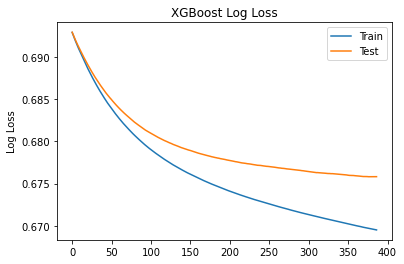

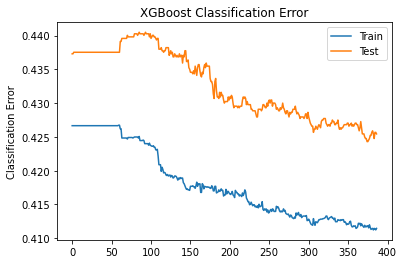

In [39]:
import matplotlib.pyplot as pyplot

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [40]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, RFECV

from sklearn.metrics import accuracy_score, make_scorer


# Define the XGBoost classifier
#model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the scoring metric (accuracy)
scorer = make_scorer(accuracy_score)

# Set the hyperparameter search space
param_grid = {
    'n_estimators': [100], # 
    'max_depth': [ 4, 5, 3], # , 6
    'learning_rate': [0.05, 0.1], # , 0.2
    #'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer, verbose=2)



grid_search.fit(X_val, y_val)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.6s
[CV] END colsample_bytree=0.8, 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.007, max...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,


In [41]:
from sklearn.feature_selection import SelectFromModel
model = XGBClassifier(**params)
model.fit(X_train, y_train)

for thresh in [125, 115, 105, 95, 85, 75]:
    # select features using threshold
    selection = SelectFromModel(model, max_features=thresh, prefit = True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(**params)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)

    print(cross_val_score(selection_model, select_X_train, y_train).mean())
    print("Thresh=%.9f, n=%d" % (thresh, select_X_train.shape[1]))

0.5746316712473096
Thresh=125.000000000, n=10
0.5746316712473096
Thresh=115.000000000, n=10
0.5746316712473096
Thresh=105.000000000, n=10
0.5746316712473096
Thresh=95.000000000, n=10
0.5746316712473096
Thresh=85.000000000, n=10
0.5746316712473096
Thresh=75.000000000, n=10
